<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW5_prob2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
# Features: X1=area, X2=bedrooms, X3=bathrooms, X4=stories, X5=parking
# Train/Val = 80/20, 5000 epochs, LR in {0.1, 0.01, 0.001, 0.0001}
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
EPOCHS       = 5000
LRS          = [0.1, 0.01, 0.001, 0.0001]
DENSE_LOG    = 1          # log every epoch (for smooth curves)
REPORT_STEP  = 500        # print every 500 epochs (per instruction)
USE_MOMENTUM = True

torch.manual_seed(0) #reproducibility
dtype = torch.float64

df = pd.read_csv("/content/drive/My Drive/ML/HW2/Housing.csv")
cols = ["area", "bedrooms", "bathrooms", "stories", "parking", "price"]
df = df[cols].copy()

In [169]:
# Built FULL tensors (considering 5 features as instructed)

X_full = torch.tensor(
    df[["area","bedrooms","bathrooms","stories","parking"]].astype(float).values,
    dtype=dtype
)
y_full = torch.tensor(df["price"].astype(float).values, dtype=dtype).view(-1, 1)

In [170]:
# 80/20 split using PyTorch

N = X_full.shape[0]
n_train = int(0.8 * N)
g = torch.Generator().manual_seed(42)
perm = torch.randperm(N, generator=g)
idx_tr, idx_va = perm[:n_train], perm[n_train:]

X_train_raw = X_full[idx_tr]
y_train_raw = y_full[idx_tr]
X_val_raw   = X_full[idx_va]
y_val_raw   = y_full[idx_va]


y_train = y_train_raw.detach().cpu().numpy().flatten()
y_val   = y_val_raw.detach().cpu().numpy().flatten()

In [171]:
# Standardization

mu_X_t = X_train_raw.mean(dim=0)
sd_X_t = X_train_raw.std(dim=0) + 1e-8
Xt = (X_train_raw - mu_X_t) / sd_X_t
Xv = (X_val_raw   - mu_X_t) / sd_X_t

yt = y_train_raw.to(dtype)
yv = y_val_raw.to(dtype)

class LinReg(torch.nn.Module):
    def __init__(self, d):
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros(d, 1, dtype=dtype))
        self.b = torch.nn.Parameter(torch.zeros(1, dtype=dtype))
    def forward(self, X):
        return X @ self.w + self.b

def mse(yhat, y):
    return torch.mean((yhat - y) ** 2)

def train_once(lr, epochs=EPOCHS, log_every=DENSE_LOG):

    torch.manual_seed(0)
    model = LinReg(5)
    if USE_MOMENTUM:
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        opt = torch.optim.SGD(model.parameters(), lr=lr)

    history = []
    for ep in range(epochs + 1):
        yhat = model(Xt)
        loss = mse(yhat, yt)
        opt.zero_grad(); loss.backward(); opt.step()

        if ep % log_every == 0:
            with torch.no_grad():
                tr = float(loss.item())
                vl = float(mse(model(Xv), yv).item())
            history.append((ep, tr, vl))


    with torch.no_grad():
      tr_pred = model(Xt).detach().cpu().numpy().flatten()
      va_pred = model(Xv).detach().cpu().numpy().flatten()
    tr_mse = float(np.mean((tr_pred - y_train) ** 2))
    va_mse = float(np.mean((va_pred - y_val) ** 2))


    with torch.no_grad():
      w_scaled = model.w.view(-1).detach().cpu().numpy()
      b_scaled = float(model.b.item())
      return {
          "history": history,
          "tr_mse": tr_mse,
          "va_mse": va_mse,
          "w_scaled": w_scaled,
          "b_scaled": b_scaled,
          "val_pred": va_pred
          }




In [172]:
runs = {lr: train_once(lr=lr) for lr in LRS}
# Pick best by validation MSE
best_lr = min(LRS, key=lambda a: runs[a]["va_mse"])
best = runs[best_lr]


In [173]:
print("\nTrain/Validation MSE every 500 epochs")
epochs_logged = list(range(0, EPOCHS + 1, REPORT_STEP))
for lr in LRS:
    print(f"\nLR = {lr}")
    hist = {ep: (tr, vl) for (ep, tr, vl) in runs[lr]["history"]}
    for ep in epochs_logged:
        tr, vl = hist.get(ep, (float('nan'), float('nan')))
        print(f"  epoch {ep:4d}  train_MSE={tr:.6f}   val_MSE={vl:.6f}")


Train/Validation MSE every 500 epochs

LR = 0.1
  epoch    0  train_MSE=26305958620363.761719   val_MSE=16329315500529.310547
  epoch  500  train_MSE=1589941251792.558105   val_MSE=1326688359163.269531
  epoch 1000  train_MSE=1589941251792.557861   val_MSE=1326688359163.061523
  epoch 1500  train_MSE=1589941251792.558105   val_MSE=1326688359163.062012
  epoch 2000  train_MSE=1589941251792.558105   val_MSE=1326688359163.061523
  epoch 2500  train_MSE=1589941251792.558105   val_MSE=1326688359163.062012
  epoch 3000  train_MSE=1589941251792.557861   val_MSE=1326688359163.061523
  epoch 3500  train_MSE=1589941251792.558105   val_MSE=1326688359163.062012
  epoch 4000  train_MSE=1589941251792.558105   val_MSE=1326688359163.061523
  epoch 4500  train_MSE=1589941251792.558105   val_MSE=1326688359163.062012
  epoch 5000  train_MSE=1589941251792.557861   val_MSE=1326688359163.061523

LR = 0.01
  epoch    0  train_MSE=26305958620363.761719   val_MSE=24784743673160.503906
  epoch  500  train_MSE=

In [174]:
mse_tr  = best['tr_mse']
mse_val = best['va_mse']
rmse_tr  = math.sqrt(mse_tr)
rmse_val = math.sqrt(mse_val)

print("\nFinal metrics")
print(f"Training loss: MSE = {mse_tr:,.0f}   RMSE = {rmse_tr:,.0f}")
print(f"Validation loss  : MSE = {mse_val:,.0f}   RMSE = {rmse_val:,.0f}")



Final metrics
Training loss: MSE = 1,589,942,087,791   RMSE = 1,260,929
Validation loss  : MSE = 1,326,229,801,998   RMSE = 1,151,621


In [175]:
W1, W2, W3, W4, W5 = best["w_scaled"]  # [area, bedrooms, bathrooms, stories, parking]
B = best["b_scaled"]

print("\nBest linear model:")
print("U = W5*X5 + W4*X4 + W3*X3 + W2*X2 + W1*X1 + B")
print(f"  W1 (area)      = {W1:.6f}")
print(f"  W2 (bedrooms)  = {W2:.6f}")
print(f"  W3 (bathrooms) = {W3:.6f}")
print(f"  W4 (stories)   = {W4:.6f}")
print(f"  W5 (parking)   = {W5:.6f}")
print(f"  B              = {B:.6f}")


Best linear model:
U = W5*X5 + W4*X4 + W3*X3 + W2*X2 + W1*X1 + B
  W1 (area)      = 754694.557326
  W2 (bedrooms)  = 57669.561864
  W3 (bathrooms) = 576173.012618
  W4 (stories)   = 474629.289554
  W5 (parking)   = 335288.137543
  B              = 4758646.359436


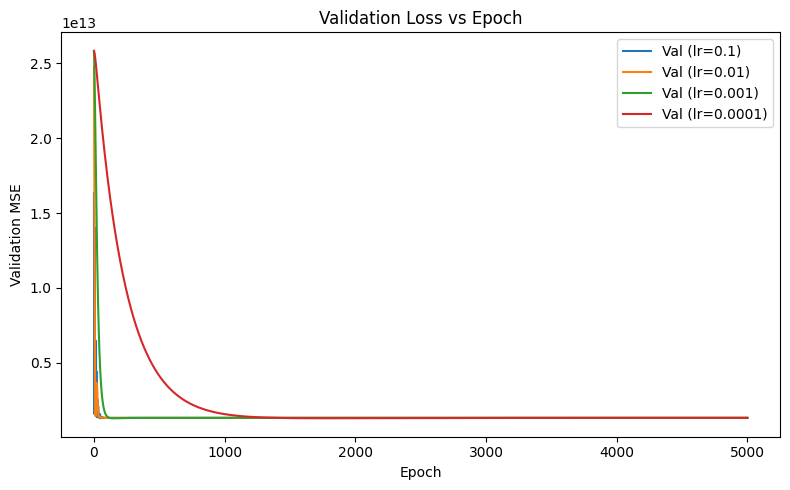

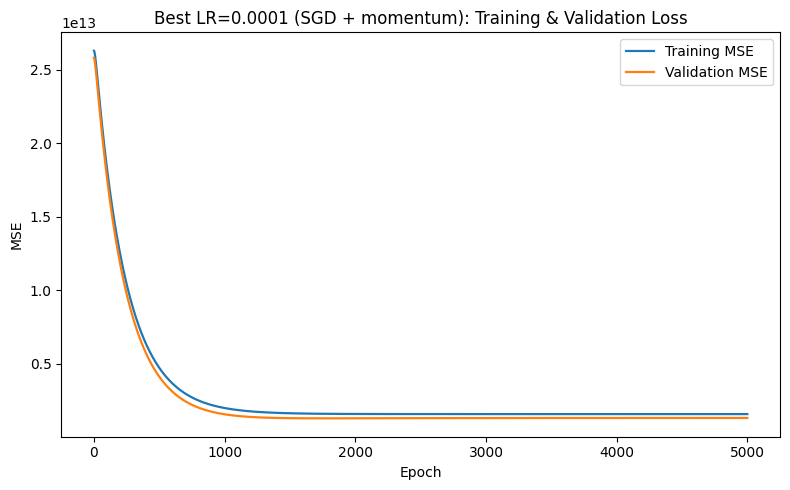

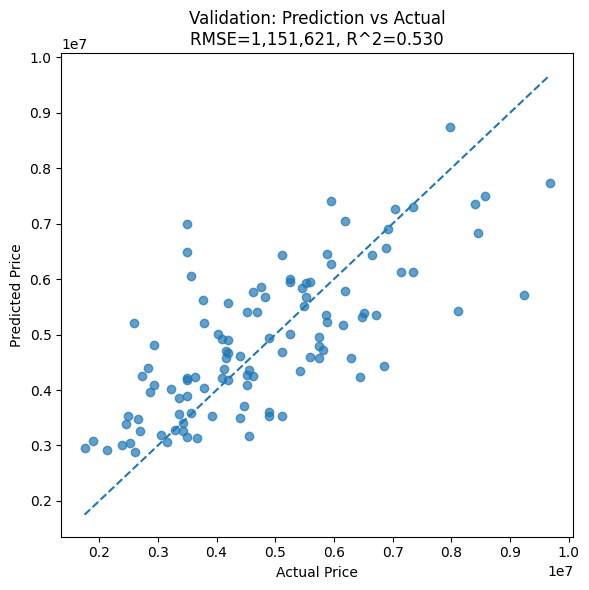

In [176]:
def _smooth(arr, k=21):
    if k <= 1 or k > len(arr): return arr
    w = np.ones(k) / k
    return np.convolve(arr, w, mode="same")

# Validation loss vs Epoch (all LRs)
plt.figure(figsize=(8,5))
for lr in LRS:
    hist = runs[lr]["history"]
    ep = np.array([h[0] for h in hist])
    vl = np.array([h[2] for h in hist])
    plt.plot(ep, vl, linewidth=1.5, label=f"Val (lr={lr})")
plt.xlabel("Epoch"); plt.ylabel("Validation MSE")
plt.title("Validation Loss vs Epoch")
plt.legend(); plt.tight_layout(); plt.show()

# Best LR – Train & Val loss vs Epoch
hist = best["history"]
ep = np.array([h[0] for h in hist])
tr = np.array([h[1] for h in hist])
vl = np.array([h[2] for h in hist])


plt.figure(figsize=(8,5))
plt.plot(ep, tr, linewidth=1.6, label="Training MSE")
plt.plot(ep, vl, linewidth=1.6, label="Validation MSE")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.title(f"Best LR={best_lr} (SGD{' + momentum' if USE_MOMENTUM else ''}): Training & Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

# Prediction vs Actual (Validation)
y_val_pred = best["val_pred"]
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))
r2_val   = r2_score(y_val, y_val_pred)

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, alpha=0.7)
mn = min(y_val.min(), y_val_pred.min()); mx = max(y_val.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel("Actual Price"); plt.ylabel("Predicted Price")
plt.title(f"Validation: Prediction vs Actual\nRMSE={rmse_val:,.0f}, R^2={r2_val:.3f}")
plt.tight_layout(); plt.show()
